https://learn.qiskit.org/v1/course/ch-algorithms/defining-quantum-circuits

In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.visualization import plot_histogram

# importing Qiskit
from qiskit.quantum_info import SparsePauliOp
from qiskit.opflow import I, X, Y, Z, H, CX, Zero, ListOp, PauliExpectation, PauliTrotterEvolution, CircuitSampler, MatrixEvolution, Suzuki, PauliSumOp
from qiskit.circuit import Parameter


In [2]:
import numpy as np
import scipy.linalg as la
des = [7/8, 3/8]
n = len(des)
s = np.diag(des)
q, _ = la.qr(np.random.rand(n, n))
A = q.T @ s @ q
eigs_h, vecs_h = np.linalg.eig(A)
print(eigs_h)
U = la.expm(1j*A)
eigs_u, vecs_u = np.linalg.eig(U)
print(eigs_u)

[0.875 0.375]
[0.64099686+0.7675435j  0.93050762+0.36627253j]


In [33]:
n_of_qubs = 10
qpe = QuantumCircuit(n_of_qubs+1, n_of_qubs)
qpe.initialize(vecs_u[0], n_of_qubs)

In [34]:
for qubit in range(n_of_qubs):
    qpe.h(qubit)

In [35]:
# def get_gate(A, n):    
#     pauli_op = PauliSumOp(SparsePauliOp.from_operator(A))
#     phi = Parameter('ϕ')
#     evolution_op = (phi * pauli_op).exp_i() # exp(-iϕA)
#     trotterized_op = PauliTrotterEvolution(trotter_mode=Suzuki(order=2, reps=1)).convert(evolution_op).bind_parameters({phi: np.pi/n})
#     #----control---------
#     gate = trotterized_op.to_circuit()
#     gate.name = f"e^(i*A*pi/{n})"
#     gate.label = f"e^(i*A*np.pi/{n})"
#     gate = gate.to_gate().control()
#     #---------------------
#     return gate

In [36]:
from qiskit.quantum_info.operators import Operator
from qiskit.extensions import UnitaryGate
from qiskit.circuit.add_control import add_control
gate = UnitaryGate(U).control(1)
repetitions = 1
for i in range(0, n_of_qubs):
    for _ in range(repetitions):
        qpe.append(gate,[i, n_of_qubs])
    repetitions *= 2

In [37]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)

In [38]:
qpe.barrier()
# Apply inverse QFT
qft_dagger(qpe, n_of_qubs)
# Measure
qpe.barrier()
for n in range(n_of_qubs):
    qpe.measure(n,n)

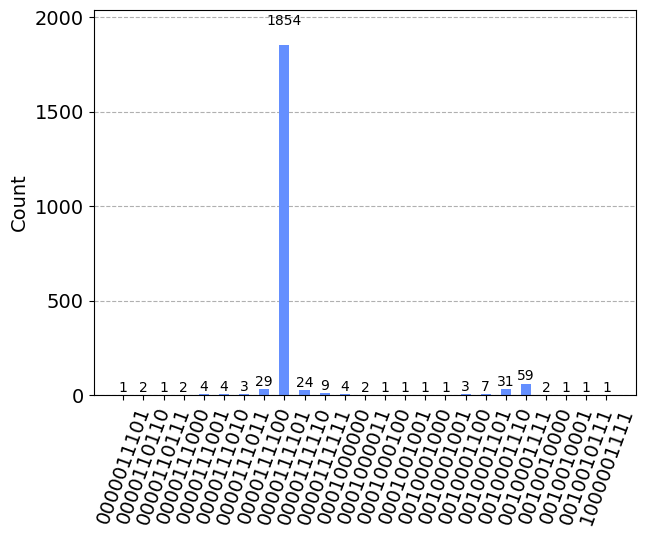

In [39]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_qpe = transpile(qpe, aer_sim)
qobj = assemble(t_qpe, shots=shots)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
answer_to_plot = answer.copy()
answer = sorted(answer.items(), key=lambda x:x[1])
new_ans = []
for pair in answer:
    new_ans.append((int(pair[0],2), pair[1]))
answer = new_ans
plot_histogram(answer_to_plot)

In [40]:
print(answer)

[(527, 1), (73, 1), (55, 1), (136, 1), (151, 1), (145, 1), (29, 1), (137, 1), (68, 1), (56, 2), (144, 2), (67, 2), (54, 2), (59, 3), (140, 3), (64, 4), (58, 4), (57, 4), (141, 7), (63, 9), (62, 24), (60, 29), (142, 31), (143, 59), (61, 1854)]


In [43]:
import scipy.linalg as la
print(la.expm(1j*4*np.pi*61/shots))

[[0.93076696+0.365613j]]


In [44]:
eigs_u

array([0.64099686+0.7675435j , 0.93050762+0.36627253j])

In [45]:
eigs_h

array([0.875, 0.375])

In [46]:
4*np.pi*61/shots

0.37429131224409645